In [10]:
# Figure 8
## Total accumulated precipitation (mm) associated with the top 10  HIPEs detected in the Alpine region during 1961–2022. 

In [4]:
library(tidyverse)
library(terra)
library(giscoR)
library(sf)
library(metR)
library(cptcity)

setwd("/mnt/CEPH_PROJECTS/HIPEAtMount/HIPEAtMount-WP1")
source("Script/Functions/theme_plot.R")


Attaching package: ‘metR’


The following object is masked from ‘package:purrr’:

    cross




In [2]:
## ---- Borders & geographic context ----------------------------------------
# Getting Alpine and neighboring borders
borders <- giscoR::gisco_get_countries(country = c(
  "Italy","Switzerland","France","Austria","Slovenia",
  "Germany","Croatia","Bosnia"
), resolution = "03")

world <- giscoR::gisco_coastallines

borders_w_nuts <- giscoR::gisco_get_nuts(year = 2021, resolution = "03", nuts_level = 0) %>%
    st_transform(crs = st_crs(borders))

# Alpine convention borders
borders_convention <- read_sf("Data/Borders/Alpine_Convention_Perimeter_2018_v2/Alpine_Convention_Perimeter_2018_v2.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()

# HISTALP borders
HISTALP_borders <- read_sf("Data/Borders/Shape_CRSM/Shape_CRSM.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()

# Intersecting HISTALP with Alpine convention borders
GAR_HISTALP_intersect <- st_intersection(borders_convention, HISTALP_borders) %>% 
  dplyr::select(Id.1) %>% 
  dplyr::rename(Regions = Id.1) %>%
  mutate(
    Regions = ifelse(Regions == 0, "Southwest", Regions),
    Regions = ifelse(Regions == 1, "Northwest", Regions),
    Regions = ifelse(Regions == 2, "Northeast", Regions),
    Regions = ifelse(Regions == 3, "Southeast", Regions)
  )

# River network in the Alpine convention
rivers <- rnaturalearth::ne_download(scale = 10, type = 'rivers_lake_centerlines', category = 'physical') %>%
  st_intersection(borders_convention)

# Extent ALpine region
sample_4_extent <- rast("Data/APGD/harmonised/RapdD_al05_19710100_harm.nc")[[1]]
extent <- ext(sample_4_extent)

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Reading ne_10m_rivers_lake_centerlines.zip from naturalearth...
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


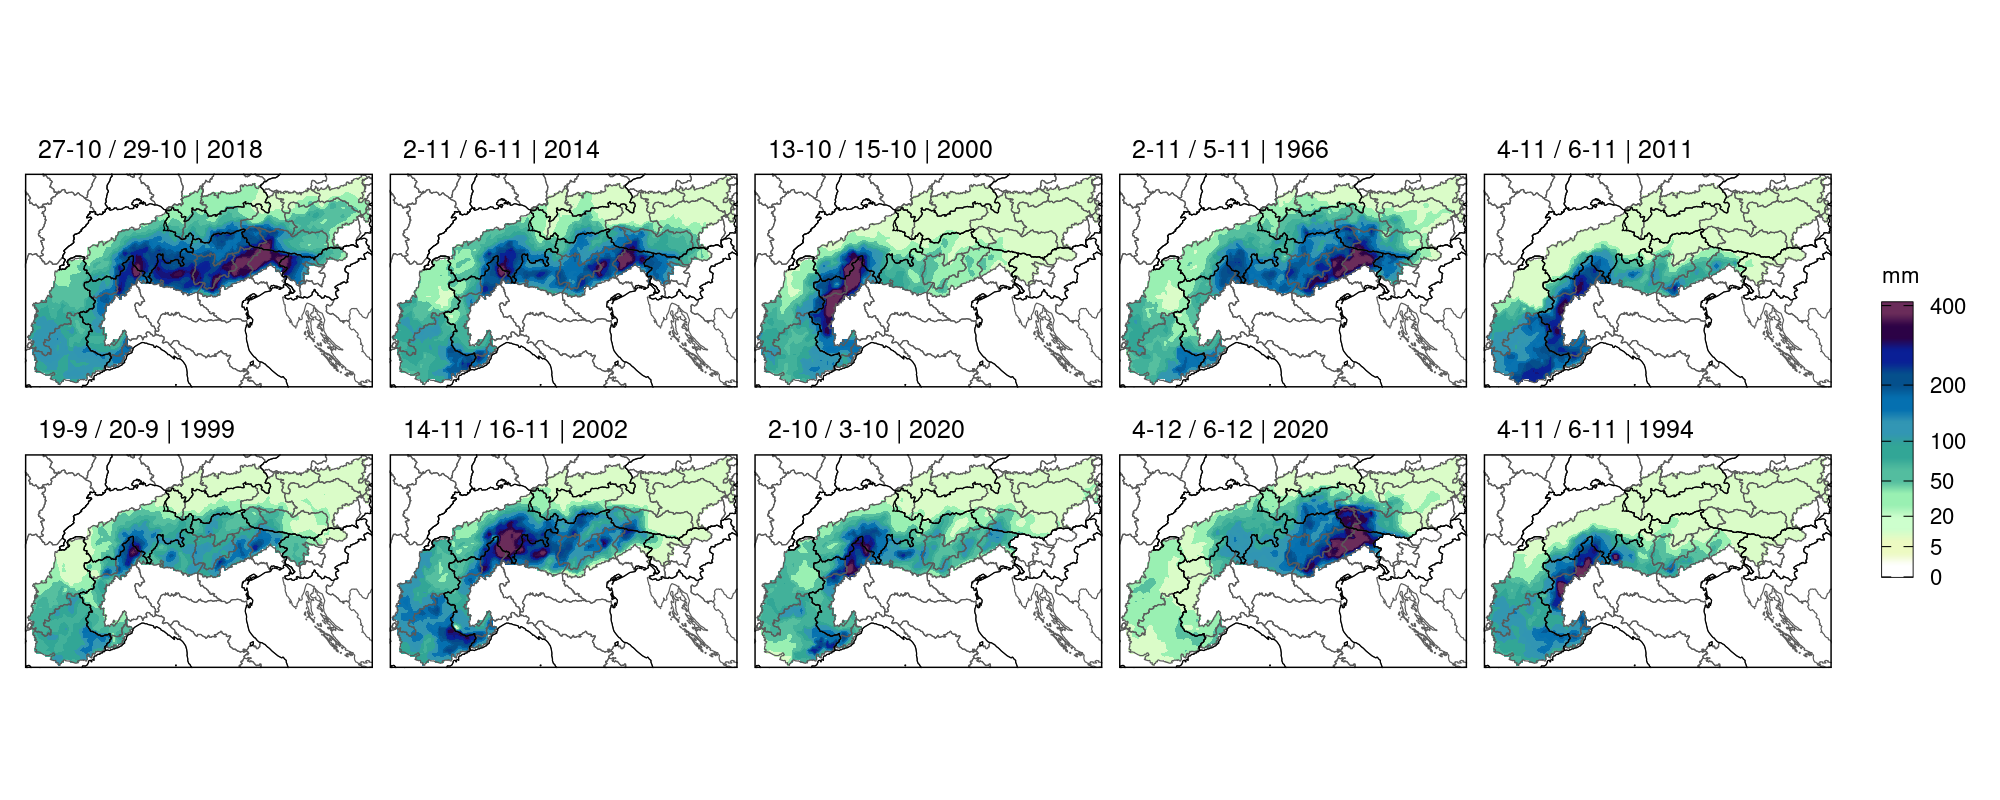

In [5]:
HIPE_db_grid <- read_rds("Output/Data/2_ranking_databases/ACPD_complete_ranking/ACPD_HIPE_Ranking_1961-2022_multiday_gridded.rds") 
Events <- HIPE_db_grid$Event %>% unique()

TOP10_HIPE <- HIPE_db_grid %>%
  filter(Event %in% unique(Event)[1:10])

# Creating a new variable (facet_var) to oder the plots by M instead of their time sequence
TOP10_HIPE$facet_var <- factor(TOP10_HIPE$label_dates, levels = rev(unique(TOP10_HIPE$label_dates[order(TOP10_HIPE$M)])))

sample_4_extent <- rast("Data/APGD/harmonised/RapdD_al05_19710100_harm.nc")[[1]]
extent <- ext(sample_4_extent)

## Plotting precipitation of Top 5 events
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200)
ggplot()+
  geom_contour_fill(data = mutate(TOP10_HIPE, P_H = ifelse(P_H >400,400,P_H)), 
                    aes(lon,lat,z = P_H),
                    breaks = seq(0,500,20))+
  geom_sf(data = borders_w_nuts, fill = "transparent")+
  geom_sf(data = borders_convention, fill = "transparent")+
  scale_fill_gradientn(colours = cpt(pal = "ncl_precip_11lev"), 
                       limits = c(0,410),
                       breaks = c(0,5,20,50,100,200,400),
                       name = "mm",
                       trans = "sqrt")+
  facet_wrap(~facet_var, ncol = 5) +
  guides(fill = guide_colorbar(
    title = "mm",
    title.position = "top",
    barwidth = unit(0.4, "cm"),
    barheight = unit(3.5, "cm"),
    frame.linewidth = 0.15,
    frame.colour = "black",
    ticks.colour = "black")) +
  labs(y = "Annual precipitation")+
  geom_sf(data = borders, fill = NA, color = "black") +
  scale_x_continuous(limits = c(extent[1]+0.3, extent[2]+0.1), expand = c(0, 0),
                     breaks = seq(6,14,4)) +
  scale_y_continuous(limits = c(extent[3]+0.2, extent[4]-0.1), expand = c(0, 0),
                     breaks = seq(44,48,2)) +
  theme_4paper +
  theme(axis.text = element_blank(),
        axis.title.y = element_blank(),
       axis.ticks = element_blank())